first try rt-dert. here we did not include "difficult" examples

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.2 which is incompatible.
pytensor 2.26.4 requires numpy<2,>=1.17.0, but you have numpy 2.2.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.2 which is incompatible.
langchain 0.3.15 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.2.2 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q torchmetrics
!pip install wandb # Weights and Biases
!pip install -q "albumentations>=1.4.5"


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 88.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB

In [ ]:
import wandb
wandb.init(mode="disabled")


In [ ]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
#this allow to get a pretrained checkpoint of a previous trained model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import os

annotations_train_path = "/content/drive/MyDrive/Vision_project/trial_DERT_camilo/annotations_training_coco_updated.json"
annotations_test_path = "/content/drive/MyDrive/Vision_project/trial_DERT_camilo/annotations_testing_coco_updated.json"
source_images_folder = "/content/drive/MyDrive/Vision_project/processed_images"
output_train_folder = "/content/drive/MyDrive/Vision_project/Trial_yolo_camilo/train_images"
output_test_folder = "/content/drive/MyDrive/Vision_project/Trial_yolo_camilo/test_images"
DATASET_PATH = "/content/drive/MyDrive/Vision_project/trial_DERT_camilo"
TRAIN_DIRECTORY = os.path.join(DATASET_PATH, "train_images")
TEST_DIRECTORY = os.path.join(DATASET_PATH, "test_images")

In [ ]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=TRAIN_DIRECTORY,
    annotations_path=annotations_train_path,
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=TEST_DIRECTORY,
    annotations_path=annotations_test_path,
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")


Number of training images: 1208
Number of validation images: 120


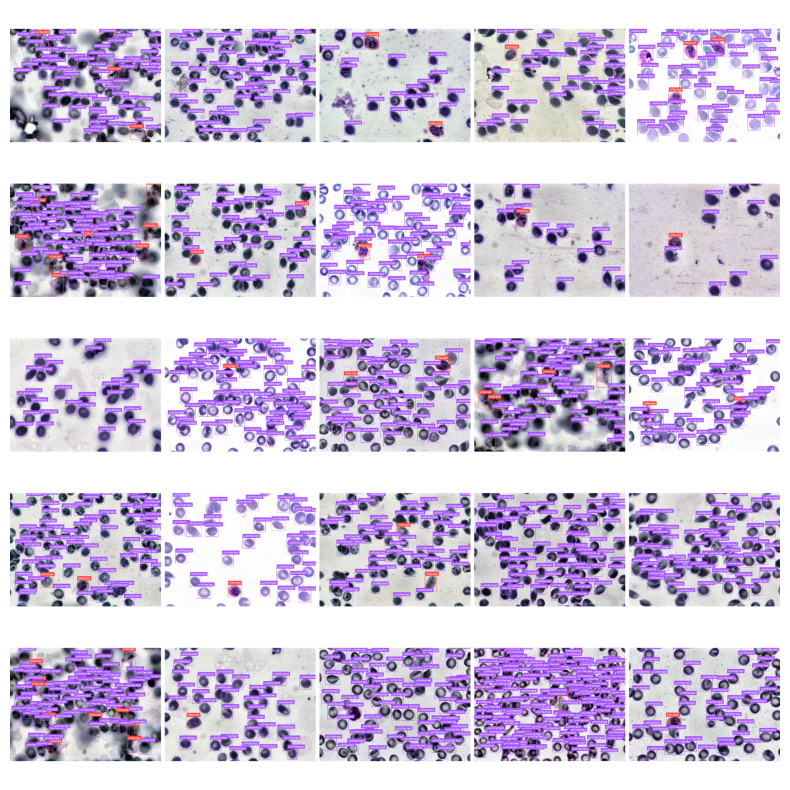

In [ ]:


GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

In [ ]:
IMAGE_SIZE = 640
 #processor for the model using the same iamge size for YOLO
processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

In [ ]:
#aUGMENTATIONS
train_augmentation_and_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Perspective(p=0.1),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        A.GaussianBlur(blur_limit=(5, 9), sigma_limit=(0.1, 2.0), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GridDistortion(p=0.3),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

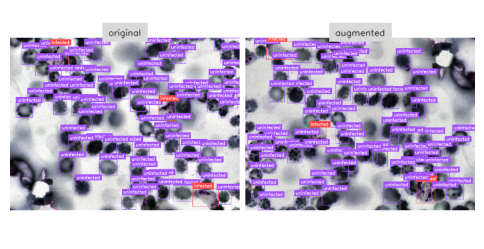

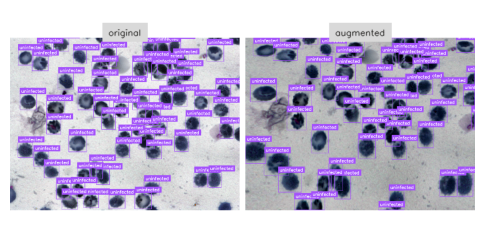

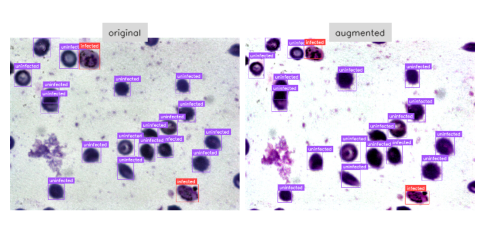

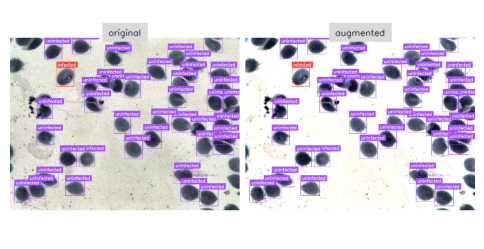

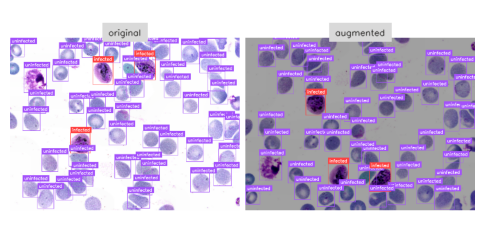

In [ ]:
#vISUALIZE ONE IMAGE WITH THE ANNOTATIONS

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
#wIT THIS CLASS we can rpeparet he iamges and annotations for the DERT model, for this we apply the transformations to get the COCO format
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        result = {k: v[0] for k, v in result.items()}

        return result

In [ ]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.7804, 0.8157, 0.8784,  ..., 0.6706, 0.5608, 0.4902],
          [0.7412, 0.7882, 0.8588,  ..., 0.6431, 0.5569, 0.4941],
          [0.6824, 0.7451, 0.8235,  ..., 0.6039, 0.5412, 0.4902],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.7843, 0.8235, 0.8941,  ..., 0.7020, 0.5843, 0.5098],
          [0.7451, 0.7961, 0.8667,  ..., 0.6745, 0.5804, 0.5137],
          [0.6980, 0.7529, 0.8235,  ..., 0.6353, 0.5686, 0.5216],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.8941, 0.9216, 0.9686,  ..., 0.7765, 0.6667, 0.5961],
          [0.8667, 0.8980, 0.9529,  ..., 0.7608, 0.6745, 0.6196],
          [0.8235, 0.862

In [ ]:
# use this collate function to get the batches for the model
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [ ]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

In [ ]:
#Model definition
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.

In [ ]:
#Trainning parameters
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Vision_project/trial_DERT_camilo/DETR_model_flavio_2",
    num_train_epochs=12,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=8,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Uninfected,Mar 100 Uninfected,Map Infected,Mar 100 Infected
1,No log,8.599151,0.524600,0.648700,0.612200,0.012000,0.526400,-1.000000,0.153100,0.455000,0.722000,0.175000,0.722100,-1.000000,0.491100,0.637700,0.558000,0.806200
2,No log,7.941448,0.548800,0.679200,0.647300,0.076700,0.549700,-1.000000,0.154800,0.473200,0.755700,0.400000,0.755800,-1.000000,0.512500,0.679900,0.585100,0.831500
3,No log,7.934914,0.530600,0.659900,0.630300,0.025700,0.532000,-1.000000,0.148300,0.443200,0.744400,0.225000,0.744500,-1.000000,0.546200,0.688100,0.514900,0.800600
4,10.704100,7.656219,0.563300,0.692800,0.666300,0.120000,0.564100,-1.000000,0.151300,0.458700,0.766700,0.575000,0.766700,-1.000000,0.552800,0.705100,0.573900,0.828200
5,10.704100,7.640655,0.557300,0.682800,0.662700,0.122700,0.563000,-1.000000,0.151500,0.450400,0.775100,0.325000,0.775200,-1.000000,0.556100,0.720600,0.558600,0.829500
6,10.704100,7.616397,0.523300,0.646200,0.622700,0.293400,0.525700,-1.000000,0.146500,0.394800,0.731400,0.550000,0.731500,-1.000000,0.588800,0.723200,0.457900,0.739600
7,9.927000,7.121382,0.588700,0.723500,0.695800,0.398000,0.590400,-1.000000,0.155900,0.428100,0.778600,0.550000,0.778700,-1.000000,0.635500,0.761500,0.542000,0.795800
8,9.927000,7.357003,0.579200,0.715500,0.681100,0.145400,0.581900,-1.000000,0.148900,0.444600,0.766900,0.525000,0.767000,-1.000000,0.619400,0.745500,0.538900,0.788300
9,9.927000,7.363471,0.580500,0.715800,0.691500,0.304300,0.583600,-1.000000,0.154400,0.446800,0.773100,0.575000,0.773200,-1.000000,0.611800,0.740400,0.549200,0.805800
10,9.428200,7.476886,0.562500,0.698600,0.664700,0.328700,0.565100,-1.000000,0.146100,0.415700,0.758200,0.325000,0.758300,-1.000000,0.616800,0.740700,0.508100,0.775600


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=1812, training_loss=9.887655969750275, metrics={'train_runtime': 3328.7845, 'train_samples_per_second': 4.355, 'train_steps_per_second': 0.544, 'total_flos': 4.566849688122163e+18, 'train_loss': 9.887655969750275, 'epoch': 12.0})

In [ ]:
# Collect predictions

targets = []
predictions = []

for i in range(len(ds_valid)):
    path, sourece_image, annotations = ds_valid[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [ ]:

mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.64
map50: 0.75
map75: 0.73


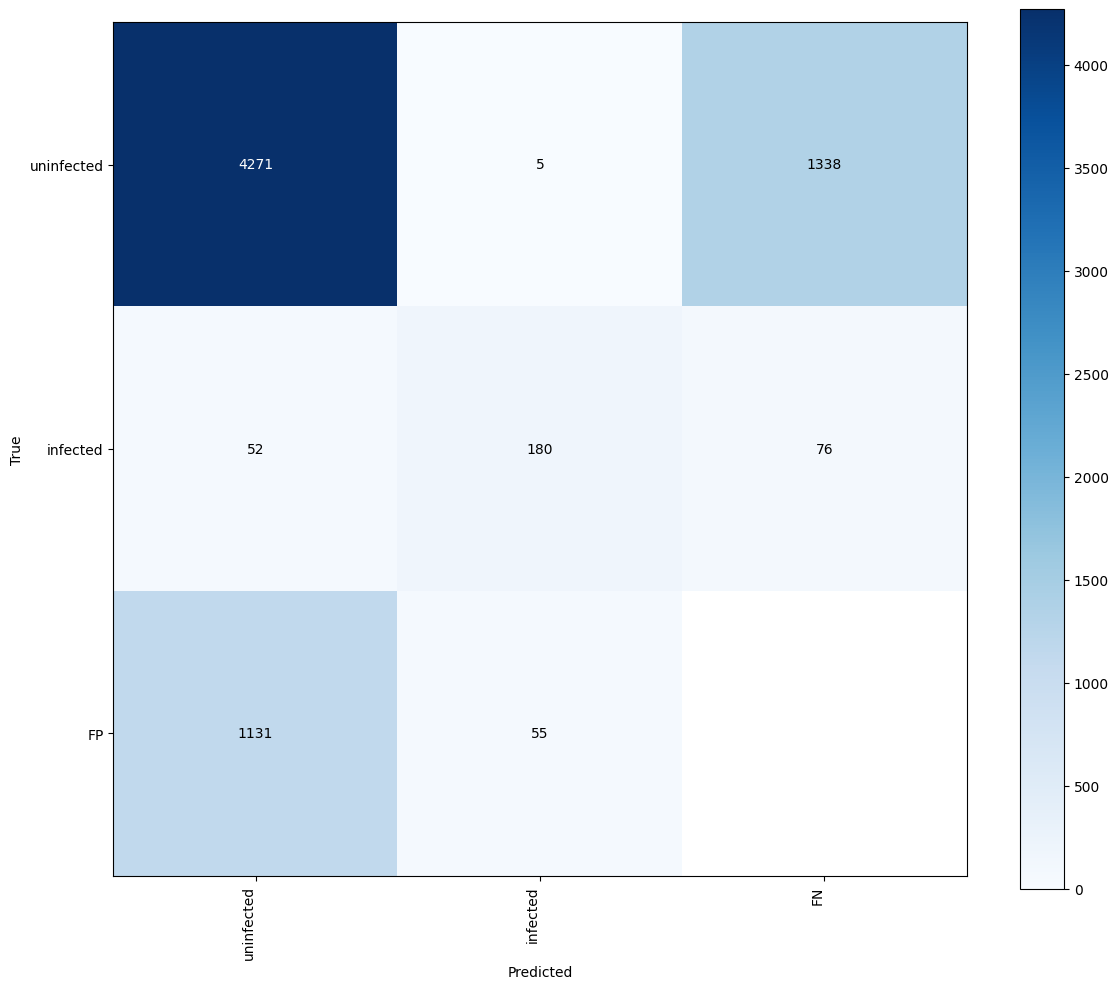

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_valid.classes
)

_ = confusion_matrix.plot()

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Vision_project/trial_DERT_camilo/DETR_model_flavio_2")
processor.save_pretrained("/content/drive/MyDrive/Vision_project/trial_DERT_camilo/DETR_model_flavio_2")

['/content/drive/MyDrive/Vision_project/trial_DERT_camilo/DETR_model_flavio_2/preprocessor_config.json']

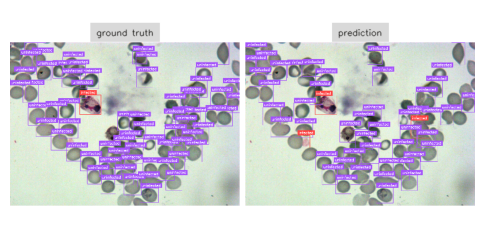

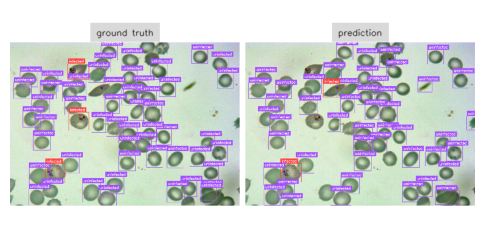

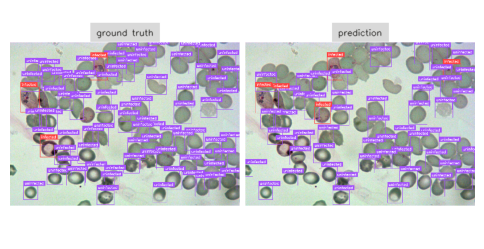

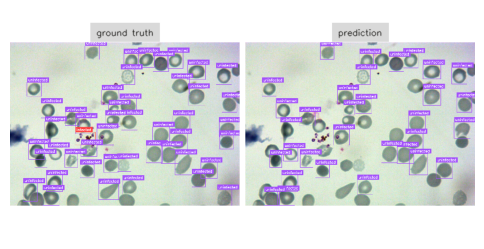

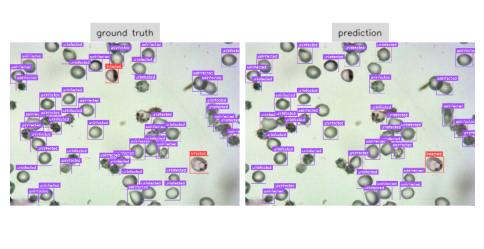

In [ ]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_valid[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
import torch
from torchvision.ops import box_iou

def calculate_metrics(targets, predictions, iou_threshold=0.4):

    category_metrics = {
        'infected': {'iou': 0, 'correct': 0, 'total': 0, 'predicted': 0, 'false_positives': 0, 'false_negatives': 0},
        'uninfected': {'iou': 0, 'correct': 0, 'total': 0, 'predicted': 0, 'false_positives': 0, 'false_negatives': 0}
    }

    for target, prediction in zip(targets, predictions):
        # Ths allow us to extract the ground fo thrut boinding boxes and update the category totals
        gt_boxes = torch.tensor(target.xyxy, dtype=torch.float32)
        gt_labels = torch.tensor(target.class_id, dtype=torch.int64)
        pred_boxes = torch.tensor(prediction.xyxy, dtype=torch.float32)
        pred_labels = torch.tensor(prediction.class_id, dtype=torch.int64)
        pred_scores = torch.tensor(prediction.confidence, dtype=torch.float32)
        for gt_label in gt_labels:
            if gt_label.item() == 1:
                category_metrics['infected']['total'] += 1
            elif gt_label.item() == 0:
                category_metrics['uninfected']['total'] += 1

        # Count predicted instances
        for pred_label in pred_labels:
            if pred_label.item() == 1:
                category_metrics['infected']['predicted'] += 1
            elif pred_label.item() == 0:
                category_metrics['uninfected']['predicted'] += 1

        if pred_boxes.size(0) > 0 and gt_boxes.size(0) > 0:
            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt_indices = set()

            for j, iou in enumerate(ious.max(dim=1)[0]):
                pred_label = pred_labels[j].item()
                gt_idx = ious[j].argmax().item()

                if gt_idx in matched_gt_indices:
                    continue
                matched_gt_indices.add(gt_idx)

                gt_label = gt_labels[gt_idx].item()

                if iou > iou_threshold:
                    if pred_label == gt_label:
                        if pred_label == 1:
                            category_metrics['infected']['correct'] += 1
                        elif pred_label == 0:
                            category_metrics['uninfected']['correct'] += 1

                if gt_label == 1:
                    category_metrics['infected']['iou'] += iou.item()
                elif gt_label == 0:
                    category_metrics['uninfected']['iou'] += iou.item()

        category_metrics['infected']['false_positives'] = category_metrics['infected']['predicted'] - category_metrics['infected']['correct']
        category_metrics['infected']['false_negatives'] = category_metrics['infected']['total'] - category_metrics['infected']['correct']
        category_metrics['uninfected']['false_positives'] = category_metrics['uninfected']['predicted'] - category_metrics['uninfected']['correct']
        category_metrics['uninfected']['false_negatives'] = category_metrics['uninfected']['total'] - category_metrics['uninfected']['correct']
 #Compute the metrics from the arrays
    for category, metrics in category_metrics.items():
        total = metrics['total']
        correct = metrics['correct']
        predicted = metrics['predicted']
        iou_sum = metrics['iou']

        metrics['avg_iou'] = iou_sum / total if total > 0 else 0
        metrics['accuracy'] = correct / total if total > 0 else 0
        metrics['precision'] = correct / predicted if predicted > 0 else 0
        metrics['recall'] = correct / total if total > 0 else 0

    return category_metrics


category_metrics = calculate_metrics(targets, predictions)

# Print results
for category, metrics in category_metrics.items():
    print(f"Category: {category}")
    print(f"  Average IoU: {metrics['avg_iou']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  False Positives: {metrics['false_positives']}")
    print(f"  False Negatives: {metrics['false_negatives']}")

Category: infected
  Average IoU: 0.6841
  Accuracy: 0.5877
  Precision: 0.7542
  Recall: 0.5877
  False Positives: 59
  False Negatives: 127
Category: uninfected
  Average IoU: 0.6799
  Accuracy: 0.7512
  Precision: 0.7732
  Recall: 0.7512
  False Positives: 1237
  False Negatives: 1397
